# Import packages

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import albumentations as A
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from ray import tune
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
plt.style.use('_mpl-gallery')

## Set Hyperparameter

In [2]:
try:
    os.mkdir("./output")
except:
    pass
PROJECT_NAME = "digit-recognizer"
DATA_PATH = os.path.join(os.getcwd()[:-8], "input", PROJECT_NAME)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
EPOCH = 5
PATIENCE = 10

## Dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        if y is not None:
            self.y = torch.LongTensor(y)
        else:
            self.y = None
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.transform(image=self.x[idx])["image"]
        if self.y is None:
            return image
        else:
            return image, self.y[idx]

In [4]:
def get_train_dataloader(only_valid_data=False, transforms=None):
    train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))

    x_train = train_data.iloc[:,1:].to_numpy(dtype=np.float32).reshape(-1, 28, 28, 1)
    y_train = train_data.label.to_numpy()
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
        test_size=0.2, random_state=1234)
    # Feature engineering
    x_train, x_valid = x_train/255, x_valid/255
    # Dataset and DataLoader
    train_transform, valid_transform = transforms
    valid_ds = CustomDataset(x_valid, y_valid, transform=valid_transform)
    valid_dataloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, pin_memory=True)
    if only_valid_data:
        return valid_dataloader
    else:
        train_ds = CustomDataset(x_train, y_train, transform=train_transform)
        train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True)
        return train_dataloader, valid_dataloader

In [5]:
def get_test_dataloader(transform=None):
    test_data  = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

    x_test = test_data.to_numpy(dtype=np.float32).reshape(-1, 28, 28, 1)
    # Feature engineering
    x_test = x_test/255
    # Dataset and DataLoader
    test_ds  = CustomDataset(x_test, None, transform=transform)
    test_dataloader  = DataLoader(test_ds, batch_size=BATCH_SIZE, pin_memory=True)

    return test_dataloader

## Data Augmentation

In [6]:
train_transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.15, 
                           scale_limit=0.2, 
                           rotate_limit=25, 
                           border_mode=cv2.BORDER_CONSTANT, p=0.75),
        ToTensorV2(),
    ])

valid_transform = A.Compose([
        ToTensorV2(),
    ])

test_transform = A.Compose([
        ToTensorV2(),
    ])

In [ ]:
def plot_images(train_dataloader):
    
    for X, y in train_dataloader:
        image_batch = X.cpu().numpy()
        label_batch = y.cpu().numpy()
        break
    
    plt.figure(figsize=(9, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].reshape(28, 28), cmap='gray')
        label = label_batch[i]
        plt.title(label)
        plt.axis("off")
    plt.show()

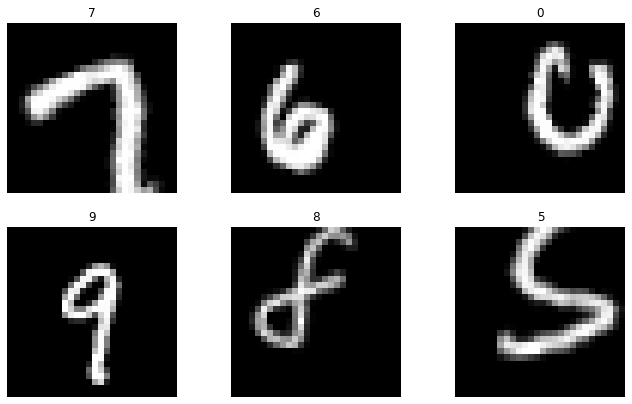

In [7]:
transforms = train_transform, valid_transform
train_dataloader, valid_dataloader = get_train_dataloader(transforms=transforms)
plot_images(train_dataloader)

## Model

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, config):
        super(NeuralNetwork, self).__init__()
        filters_1 = config["filters_1"]
        filters_2 = config["filters_2"]
        self.conv2d1 = nn.Conv2d(1, filters_1, 3)
        self.conv2d2 = nn.Conv2d(filters_1, filters_1, 3)
        self.conv2d3 = nn.Conv2d(filters_1, filters_2, 3)
        self.conv2d4 = nn.Conv2d(filters_2, filters_2, 3)
        self.maxpool2d = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.2)
        self.fc = nn.Linear(filters_2*4*4, 10)

    def forward(self, x):
        x = self.maxpool2d(F.relu(self.conv2d2(F.relu(self.conv2d1(x)))))
        x = self.maxpool2d(F.relu(self.conv2d4(F.relu(self.conv2d3(x)))))
        x = self.flatten(x)
        x = self.fc(self.dropout1(x))
        return x

## Train Model

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        loss = loss_fn(pred, y)
        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    correct /= size
    return train_loss, correct

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [11]:
def train_model(config):
    transforms = train_transform, valid_transform

    train_dataloader, valid_dataloader = get_train_dataloader(transforms=transforms)
    
    model = NeuralNetwork(config).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    current_val_accuracy = 0
    patience_count = 0

    for t in range(EPOCH):
        loss, accuracy = train(train_dataloader, model, loss_fn, optimizer)
        val_loss, val_accuracy = test(valid_dataloader, model, loss_fn)
        if patience_count == PATIENCE+1:
            break
        tune.report(
            accuracy=accuracy,
            loss=loss,
            val_accuracy=val_accuracy, 
            val_loss=val_loss)
        if current_val_accuracy < val_accuracy:
            current_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "./model.pth")
            patience_count = 0
        else:
            patience_count += 1
        

## Hyperparameter Tuning

In [12]:
search_space = {
    "filters_1": tune.grid_search([16, 32, 64]),
    "filters_2": tune.grid_search([16, 32, 64]),
    "lr": tune.grid_search([0.005, 0.01, 0.05])
    }

analysis = tune.run(
    train_model,
    config=search_space,
    resources_per_trial={'gpu': 1},
    local_dir='./output/',
    verbose=1,
    fail_fast=True
    )

2022-06-30 23:31:06,134	ERROR tune.py:743 -- Trials did not complete: [train_model_06467_00017, train_model_06467_00018, train_model_06467_00019, train_model_06467_00020, train_model_06467_00021, train_model_06467_00022, train_model_06467_00023, train_model_06467_00024, train_model_06467_00025, train_model_06467_00026]
2022-06-30 23:31:06,135	INFO tune.py:747 -- Total run time: 1131.04 seconds (1129.73 seconds for the tuning loop).
2022-06-30 23:31:06,137	WARNING tune.py:753 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


(pid=) 2022-06-30 23:31:06,424	INFO context.py:67 -- Exec'ing worker with command: "c:\Users\wayne\anaconda3\envs\DL\python.exe" c:\Users\wayne\anaconda3\envs\DL\lib\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=4763 --object-store-name=tcp://127.0.0.1:26765 --raylet-name=tcp://127.0.0.1:59025 --redis-address=None --storage=None --temp-dir=C:\Users\wayne\AppData\Local\Temp\ray --metrics-agent-port=12598 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:15441 --redis-password=5241590000000000 --startup-token=25 --runtime-env-hash=469889963


In [ ]:
print("Best hyperparameters found were:")
best_trial = analysis.get_best_trial("val_accuracy", "max", "last")

for k, v in analysis.get_all_configs().items():
    if v == best_trial.config:
        keys = k
        break
print(best_trial.config)

Best hyperparameters found were:
{'filters_1': 32, 'filters_2': 64, 'lr': 0.005}


In [ ]:
config_list = []
for i in analysis.get_all_configs().keys():
    config_list.append(analysis.get_all_configs()[i])

accury_list = []
dfs = analysis.trial_dataframes
for i, d in enumerate(dfs.values()):
    accury_list.append(d.val_accuracy.max())
# Top 3
index = sorted(range(len(accury_list)), key=lambda i: accury_list[i])[-3:]

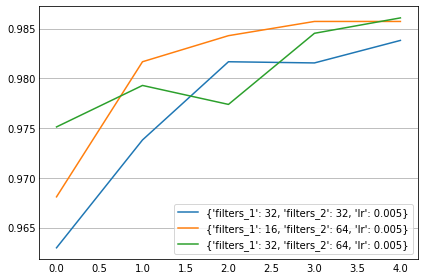

In [ ]:
plt.figure(figsize=(6, 4))
for i in index:
    dfs[list(dfs.keys())[i]].val_accuracy.plot(label=str(config_list[i]))
plt.legend()
plt.tight_layout()
plt.grid(axis='x')
plt.show()

## Vaildate the best model

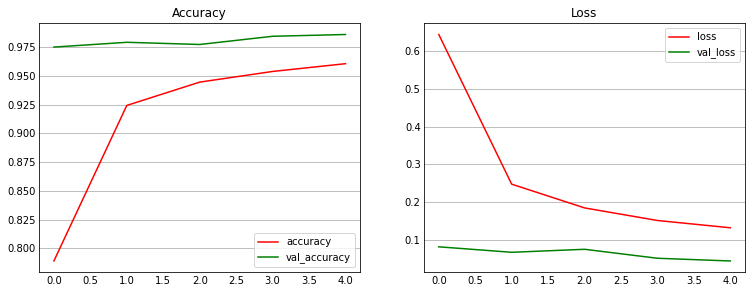

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Accuracy')
ax1.plot(dfs[keys]['accuracy'], 'r', label='accuracy')
ax1.plot(dfs[keys]['val_accuracy'], 'g', label='val_accuracy')
ax1.legend()
ax1.grid(axis='x')

ax2.set_title('Loss')
ax2.plot(dfs[keys]['loss'], 'r', label='loss')
ax2.plot(dfs[keys]['val_loss'], 'g', label='val_loss')
ax2.legend()
ax2.grid(axis='x')

plt.show()

In [ ]:
logdir = analysis.get_best_logdir("val_accuracy", mode="max")
state_dict = torch.load(os.path.join(logdir, "model.pth"))
model = NeuralNetwork(best_trial.config).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()

NeuralNetwork(
  (conv2d1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2d2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2d3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2d4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
transforms = train_transform, valid_transform

valid_dataloader = get_train_dataloader(only_valid_data=True, transforms=transforms)
y_valid = []
y_valid_pred = []

with torch.no_grad():
    for X, y in valid_dataloader:
        X = X.to(DEVICE)
        for i in y.numpy():
            y_valid.append(i)
        pred = model(X)
        for i in pred.argmax(1).cpu().numpy():
            y_valid_pred.append(i)
y_valid = np.array(y_valid)
y_valid_pred = np.array(y_valid_pred)

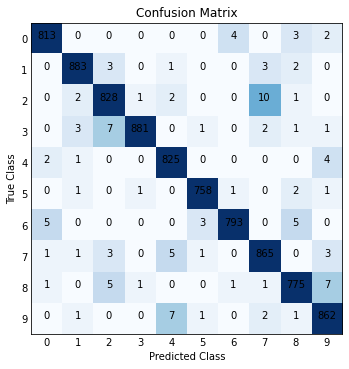

In [ ]:
matrix = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(5, 5))
plt.imshow(matrix, vmin=0, vmax=20)
for i in range(10):
    for j in range(10):
        plt.text(x=i, y=j, s=matrix[j, i], horizontalalignment='center')
plt.title("Confusion Matrix")
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.grid(0)
plt.show()

## Submit the prediction of test dataset

In [ ]:
test_dataloader = get_test_dataloader(transform=test_transform)

y_test_pred = []
with torch.no_grad():
    for X in test_dataloader:
        X = X.to(DEVICE)
        pred = model(X)
        for i in pred.argmax(1).cpu().numpy():
            y_test_pred.append(i)
y_test_pred = np.array(y_test_pred)

output = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
output['Label'] = y_test_pred
output.to_csv('./digit-recognizer.csv', index=False)